# HOG (Histogram of Oriented Gradients)

<img src="hog.png">

[HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) je algoritmus pro získání [desktriptoru](https://en.wikipedia.org/wiki/Feature_(computer_vision)) z obrázku. Jinými slovy získáme z obrázku informace, které ho nějakým způsobem popisují. Ty pak můžeme použít ke klasifikaci obrázku - typicky například rozpoznávání obličeje.

Konkrétně HOG získává [histogram](https://en.wikipedia.org/wiki/Histogram) orientovaných [gradientů](https://en.wikipedia.org/wiki/Gradient) v jednotlivých částech obrázku. Tedy v podstatě popisuje jak moc a ve kterých směrech se obrázek v jednotlivých částech mění.

[Původní článek](https://ieeexplore.ieee.org/document/1467360) je z roku 2005.

## Ukázka s využitím `skimage`

Knihovna `skimage` již obsahuje hotovou implementaci HOGu včetně vizualizace.

In [1]:
import os
import matplotlib.pyplot as plt
import cv2 
import math
import numpy as np

from skimage import feature
from skimage import data, exposure

%matplotlib inline

Načtení obrázku.

In [2]:
IMG_PATH = 'arnold.jpg'
raw = cv2.imread(IMG_PATH)
IMG_HEIGHT = 256
IMG_WIDTH = int(raw.shape[1] * (IMG_HEIGHT / raw.shape[0]))
img = cv2.resize(raw, (IMG_WIDTH, IMG_HEIGHT), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

Výpočet. Jednotlivým parametrům se budeme později věnovat u vlastní implementace.

In [3]:
ORIENTATIONS = 9
PIXELS_PER_CELL = 16
CELLS_PER_BLOCK = 2
skimage_hog_descriptor, hog_image = feature.hog(
    img,
    visualize=True,
    multichannel=True,
    orientations=ORIENTATIONS,
    pixels_per_cell=(PIXELS_PER_CELL,PIXELS_PER_CELL),
    cells_per_block=(CELLS_PER_BLOCK,CELLS_PER_BLOCK),
    feature_vector=False,
)

Vizualizace.

In [4]:
# Rescale histogram for better display - use `in_range` to clamp extreme values
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 15))

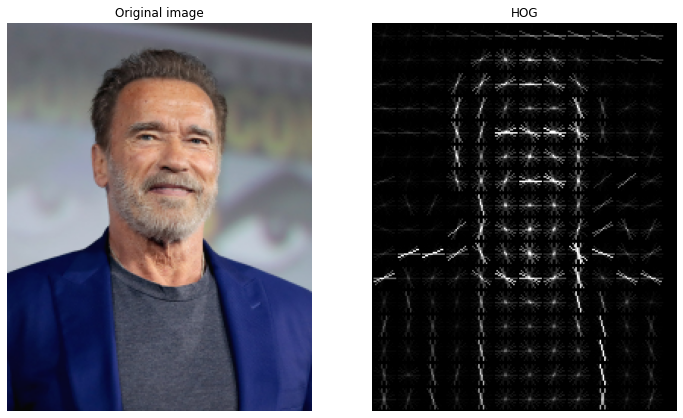

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)

ax1.axis("off")
ax1.set_title("Original image")
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.axis("off")
ax2.set_title("HOG")
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)

### Jak vypadá HOG deskriptor?

Tvar (a velikost) deskriptoru je dána velikostí vstupního obrázku a zvolených parametrů. 

První dva rozměry jsou dány poměrem velikosti obrázku k velikosti buňky. Třetí a čtvrý jsou dány velikostí bloku. Poslední je rozměr je počet binů (granularita histogramu, viz dále).

Deskriptor je často před dalším využitím (např. v klasifikátorech) zploštěn (*flatten*) na 1D pole.

In [6]:
skimage_hog_descriptor.shape

(15, 11, 2, 2, 9)

In [7]:
print('celkem prvků:', len(skimage_hog_descriptor.flatten()))

celkem prvků: 5940


## Popis algoritmu a vlastní implementace

Hlavní kroky algoritmu jsou:
- předzpracování
- výpočet gradientu
- výpočet histogramu gradientu v blocích
- normalizace mezi bloky

### Předzpracování 

<img src="pre.png" style="height: 400px;">

Budeme pracovat se stejným obrázkem jako v předchozí části. Jediným krokem předzpracování pro nás bude převod do šedotónu (a změna velikosti, kterou už jsme provedli).

In [8]:
def plot(im, figsize=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im, cmap='gray')

In [9]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

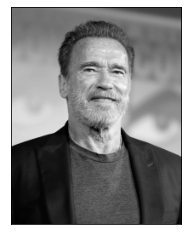

In [10]:
plot(gray)

### Výpočet gradientu

![gradient_visualisation](grad.png)

Derivaci nejdříve spočteme zvlášť ve sloupci a v řádku.

Označme $\mathit{img}_{r,c} = $ hodnota pixelu v řádku $r$ a sloupci $c$.
$$\mathit{dx}_{r,c} = \mathit{img}_{r,c+1} - \mathit{img}_{r,c-1}$$
$$\mathit{dy}_{r,c} = \mathit{img}_{r+1,c} - \mathit{img}_{r-1,c}$$

A poté v každém bodě spočítáme velikost a směr gradientu. U úhlu se omezíme na rozmezí $[0, 180)$ (to dle empirických pozorování poskytuje lepší výsledky).

$$ |\mathit{dxy}| = \sqrt{(\mathit{dx})^2 + (\mathit{dy})^2} $$ 
$$ \measuredangle{\mathit{dxy}} = \arctan{ \frac{ \mathit{dy} }{ \mathit{dx} } } $$

In [11]:
def get_gradient(img):
    h, w = img.shape[:2]

    img = img.astype(float) # prevent overflow

    # horizontal
    dx = np.zeros((h,w), dtype=float)
    for y in range(0, h):
        for x in range(1, w - 1):
            dx[y][x] = img[y][x + 1] - img[y][x - 1]
            
    # vertical
    dy = np.zeros((h,w), dtype=float)
    for y in range(1, h - 1):
        for x in range(0, w):
            dy[y][x] = img[y + 1][x] - img[y - 1][x]

            
    magnitude = np.hypot(dx, dy)
    angle = np.degrees(np.arctan2(dy, dx)) % 180

    return magnitude, angle


In [12]:
magnitudes, angles = get_gradient(gray)

### Výpočet histogramu gradientu 

<img src="histograms.png" style="height: 400px">

Obrázek si rozdělíme do *buněk* (velikost buňky je parametrem algoritmu). V každé buňce budeme počítat histogram zvlášť.

Rozsah úhlů si rozdělíme na $k$ částí ($k$ je parametrem, v angličtině pod pojmem *bins*/*orientations*). Gradienty jednotlivých pixelů pak váženě započítáme do jednotlivých částí.

![bins](bins.png)

In [13]:
def histogram_cell(magnitudes, angles, bins, step):
    hist = np.zeros(bins)
    
    for mag, angle in zip(magnitudes, angles):
        # find nearest bins
        lower_bin = int(angle // step) % bins
        higher_bin = (lower_bin + 1) % bins

        # get split proportions
        hi = (angle % step) / step
        low = 1 - hi

        hist[lower_bin] += low * mag
        hist[higher_bin] += hi * mag

    return hist

In [14]:
def get_histograms(magnitudes, angles, orientations, pixels_per_cell):
    step = 180 / orientations # note that step is float
    histograms = np.zeros((IMG_HEIGHT // pixels_per_cell, IMG_WIDTH // pixels_per_cell, orientations))
    
    for y in range(IMG_HEIGHT // pixels_per_cell):
        for x in range(IMG_WIDTH // pixels_per_cell):
            start_y = y * pixels_per_cell
            start_x = x * pixels_per_cell
            end_y = start_y + pixels_per_cell
            end_x = start_x + pixels_per_cell

            mags_loc = magnitudes[start_y:end_y, start_x:end_x]
            angles_loc = angles[start_y:end_y, start_x:end_x]

            histograms[y][x] = histogram_cell(
                mags_loc.ravel(),
                angles_loc.ravel(),
                orientations,
                step
            )
            
    return histograms

In [15]:
histograms = get_histograms(magnitudes, angles, orientations=ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL)

### Normalizace v blocích

Určíme si velikost *bloku*. Poustupně procházíme jednotlivé histogramy buněk z minulého bodu a provádíme normalizaci v rámci lokálního bloku. 

![blocks](blocks.png)

Histogram v každé buňce nahradíme normalizovanou hodnotou histogramů celého bloku.

<img src="norm_histogram.png">

Normalizace přidává odolnost proti změnám nasvícení a kontrastu.


`skimage` používá *L2-Hys* normalizaci. Nejprve definujme L2-normalizaci ($v$ je vstupní vektor, $e$ je malé reálné číslo):
$$ f(v) = \frac{v}{\sqrt{\|v\|_2^2 + e^2}} $$

L2-Hys normalizace je L2 normalizace, jejíž výsledek je omezen na maximálně 0.2, následovaná znovu L2 normalizací.

$$ g(v) = f\Big( \min\big(f(v), 0.2\big) \Big) $$

In [16]:
def normalize(block, eps=1e-5):
    # L2-Hys-norm
    out = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
    out = np.minimum(out, 0.2)
    out = out / np.sqrt(np.sum(out ** 2) + eps ** 2)
    
    return out

In [17]:
def normalize_blocks(histograms, pixels_per_cell, cells_per_block, orientations):
    normalized_rows = (IMG_HEIGHT // pixels_per_cell) - cells_per_block + 1
    normalized_cols = (IMG_WIDTH // pixels_per_cell) - cells_per_block + 1
    
    normalized_blocks = np.zeros((normalized_rows, normalized_cols,
                                  cells_per_block, cells_per_block, orientations))
    
    for r in range(normalized_rows):
        for c in range(normalized_cols):
            block = histograms[r:r + cells_per_block, c:c + cells_per_block, :]
            normalized_blocks[r, c, :] = normalize(block)
            
    return normalized_blocks

In [18]:
normalized = normalize_blocks(histograms=histograms, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, orientations=ORIENTATIONS)

### Výsledek

Tvar výsledného deskriptoru.

In [19]:
normalized.shape

(15, 11, 2, 2, 9)

Počet prvků zploštěného deskriptoru.

In [20]:
len(normalized.ravel())

5940

In [21]:
def hog(image, orientations, pixels_per_cell, cells_per_block):
    magnitudes, angles = get_gradient(image)

    histograms = get_histograms(magnitudes, angles, orientations, pixels_per_cell)
    
    normalized = normalize_blocks(histograms, pixels_per_cell, cells_per_block, orientations)
    
    return normalized.ravel()

## Vliv parametrů

Zvolené parametry mají zásadní vliv na fungování algoritmu. Jejich vliv si můžete vyzkoušet úpravou proměnných níže. Zajímavá je velikost výsledného deskriptoru, která značně ovlivňuje možnosti a složitost učení případného klasifikátoru.

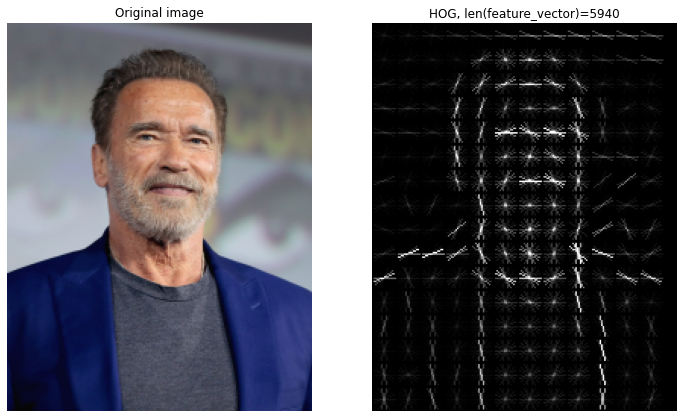

In [22]:
_orientations = 9
_pixels_per_cell = 16
_cells_per_block = 2
skimage_hog_descriptor, hog_image = feature.hog(
    img,
    visualize=True,
    multichannel=True,
    orientations=_orientations,
    pixels_per_cell=(_pixels_per_cell,_pixels_per_cell),
    cells_per_block=(_cells_per_block,_cells_per_block),
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)

ax1.axis("off")
ax1.set_title("Original image")
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.axis("off")
ax2.set_title("HOG, len(feature_vector)={}".format(len(skimage_hog_descriptor)))
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)

Tvar:

In [23]:
skimage_hog_descriptor.shape

(5940,)

## Zdroje:
    
- https://courses.fit.cvut.cz/BI-SVZ/
- https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
- https://www.learnopencv.com/histogram-of-oriented-gradients/
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
- https://lilianweng.github.io/lil-log/2017/10/29/object-recognition-for-dummies-part-1.html
- https://ieeexplore.ieee.org/document/1467360
- https://github.com/scikit-image/scikit-image